# RECURRENT NEURAL NETWORK (RNN) IMPLEMENTATION FROM FIRST PRINCIPLES

## Abstract

This notebook provides a formal mathematical implementation of a Vanilla Recurrent Neural Network (RNN) using only basic linear algebra primitives (NumPy). Unlike standard feed-forward architectures, the RNN maintains an internal hidden state h_t that acts as a differentiable memory, allowing the model to process sequences of arbitrary length T. We derive the Backpropagation Through Time (BPTT) algorithm to optimize the network's parameters (Wxh, Whh, Why, bh, by). The network is tasked with a sequence-to-scalar regression problem, mapping an input sequence to a target value representing the aggregate sum of the sequence. This implementation elucidates the temporal gradient flow and the interaction between input-to-hidden and hidden-to-hidden transformations.

# Step 1: Computational Environment

We initialize the environment with NumPy for vectorized tensor operations and Matplotlib for visualizing the convergence of the objective function.

In [46]:
import numpy as  np
import matplotlib.pyplot as plt

# Step 2: Architectural Dimensions and Hyperparameters

We define the dimensionality of the manifold. Let D be the feature space of the input, H the latent dimensionality of the hidden state, and O the output space.
 -T (Sequence Length): The number of temporal unrolling steps for BPTT.
 -lr (Learning Rate): The step size in the negative gradient direction, often denoted as eta.

In [47]:
D = 4 #input dimension (x_t)
H = 8 #hidden dimension (h_t)
O = 1 #output dimension (y)
T = 3 #sequence length
lr = 0.01 #learning rate
epochs = 300 #number of training epochs

# Step 3: Parameter Initialization

Parameters are initialized using a small Gaussian distribution to break symmetry.
  -Wxh: Weights for input-to-hidden transition (Matrix of size H x D).
  -Whh: Weights for the recurrent hidden-to-hidden transition (Matrix of size H x H).
  -Why: Weights for hidden-to-output mapping (Matrix of size O x H).

In [48]:
Wxh = np.random.randn(H, D) * 0.01 #input to hidden
Whh = np.random.randn(H, H) * 0.01 #hidden to hidden
Why = np.random.randn(O, H) * 0.01 #hidden to output
bh = np.zeros((H, 1)) #hidden bias
by = np.zeros((O, 1)) #output bias
np.random

<module 'numpy.random' from 'C:\\Users\\juanm\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages\\numpy\\random\\__init__.py'>

# Step 4: Forward Propagation 

For each time step t from 1 to T, the hidden state is updated via:
    h_t = tanh(Wxh * x_t + Whh * h_t-1 + bh)    | 
The final output is computed from the terminal hidden state h_T: 
    y = Why * h_T + by  |

In [49]:
def feedforward(xs):
    hs = {} #hidden states
    hs[0] = np.zeros((H, 1)) #initial hidden state
    for t in range(1, T + 1):
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh,hs[t-1]) + bh) #hidden state update
    y = np.dot(Why,hs[T]) + by #output
    return y,hs

# Step 5: Backpropagation Through Time (BPTT)

We apply the chain rule in reverse temporal order. For the tanh activation, the local gradient is (1 - (h_t)^2). The gradient of the loss with respect to h_t is the sum of the gradient from the output (at the final step) and the gradient flowing back from the subsequent state h_t+1.

In [50]:
def backprop(xs, hs ,y ,y_true):
    #output layer gradients
    dy = y - y_true
    dWhy = np.dot(dy, hs[T].T)
    dby = dy
    
    dh = np.dot(Why.T, dy)
    dWxh = np.zeros_like(Wxh)
    dWhh = np.zeros_like(Whh)
    dbh = np.zeros_like(bh)
    
    for t in reversed(range(1, T+1)):
        # a is the pre-activation state
        da = (1 - hs[t] ** 2)* dh
        dWxh += np.dot(da, xs[t].T)
        dWhh += np.dot(da, hs[t-1].T)
        dbh += da
        dh = np.dot(Whh.T, da)
    return dWxh, dWhh, dWhy, dbh, dby

# Step 6: Optimization Loop

We minimize the Mean Squared Error (MSE) objective: 
    Loss = 0.5 * (y - y_true)^2 using Vanilla Gradient Descent. |

In [51]:
def loss(y, y_true):
    return 0.5 * np.sum((y - y_true) ** 2)
losses = []
for epoch in range(epochs):
    # Generate random input sequence
    xs = {t: np.random.randn(D, 1) for t in range(1, T + 1)}
    y_true = np.array([[sum(np.sum(xs[t]) for t in range(1, T + 1))]])
    # Forward pass
    y, hs = feedforward(xs)
    
    # Compute loss
    current_loss = loss(y, y_true)
    losses.append(current_loss)
    
    # Backward pass
    dWxh, dWhh, dWhy, dbh, dby = backprop(xs, hs, y, y_true)
    
    #gradient descent parameter update
    Wxh -= lr * dWxh
    Whh -= lr * dWhh
    Why -= lr * dWhy
    bh -= lr * dbh
    by -= lr * dby

# Step 7: Evaluation and Convergence Visualization

The loss curve illustrates the minimization of the objective function, indicating that the network is successfully learning the temporal dependencies required to perform the summation task.

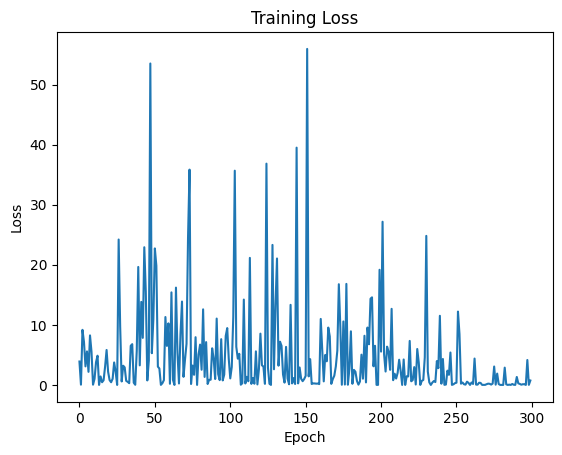

In [52]:
#plot loss curve
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Step 8: Hidden State Evolution

There we visualize the Hidden State Evolution, which provides insight into how the latent memory units activate across different time steps within the sequence.

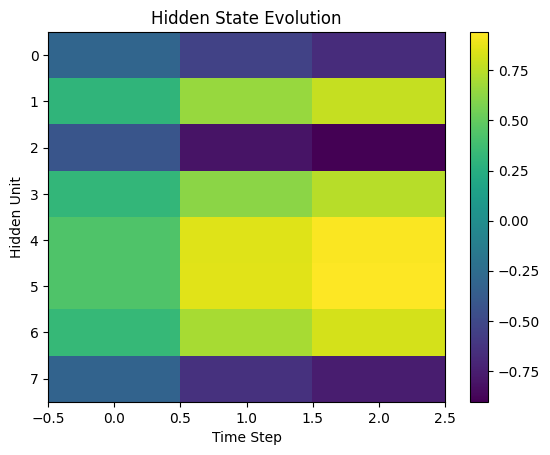

In [53]:
# Hidden state dynamics 
_, hs = feedforward(xs)
hidden_states = np.hstack([hs[t] for t in range(1, T + 1)])

plt.figure()
plt.imshow(hidden_states, aspect="auto", cmap="viridis")
plt.colorbar()
plt.xlabel("Time Step")
plt.ylabel("Hidden Unit")
plt.title("Hidden State Evolution")
plt.show()